In [2]:
#imports 
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)

Detecting Pigs and Swedish Chef based on Audio Features
This notebook documents our approach to detect Pigs and the Swedish Chef based on audio feature-engineering.
Time Sheet for this Notebook:
Alina Ehart
todo


Loadting the data
Set the booleans below to extract the audio/frames from the .avi files if it has not been done previously.

In [3]:
#loading data
extract_audio = False
extract_frames = False

In [6]:
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)

MemoryError: Unable to allocate 520. MiB for an array with shape (68215997, 2) and data type float32

Example for handling the data for video 0:

dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]

Audio Feature Extraction
Aligning audio features with video frame rate
The annotations are at the video frame level, for audio too. Therefore, we need to align the audio features with the video frames.

We start by checking the framerate of the videos and remind of our audio sampling rate:

In [ ]:
%%sh

ffprobe -v error -select_streams v:0 -show_entries stream=avg_frame_rate -of default=noprint_wrappers=1:nokey=1 ../data/Muppets-02-01-01.avi


In [4]:
FRAMES_PER_SECOND = 25

In [5]:
AUDIO_SAMPLING_RATE = dataset.audios[0]["sr"]
AUDIO_SAMPLING_RATE

44100

There are 25 frames per second, and the 16k audio samples per second.
We therefore have 1764 audio samples per frame and divide our audio features in windows of 1764 samples.

Experimentation with Audio Features
As these featues were already used in the audio notebook for SM1, we did not further inspect or use them here.

(12, 66618)
(7, 66618)
(1, 66618)
(1, 66618)
(1, 66618)
Spectral Centroid: [[   0.            0.            0.         ... 4689.93172905
  4616.20114849 4360.58678277]]
Spectral Bandwidth: [[   0.            0.            0.         ... 3345.07031956
  3311.0978618  3345.40737093]]
Spectral Roll-off: [[   0.            0.            0.         ... 8785.546875
  8731.71386719 8613.28125   ]]


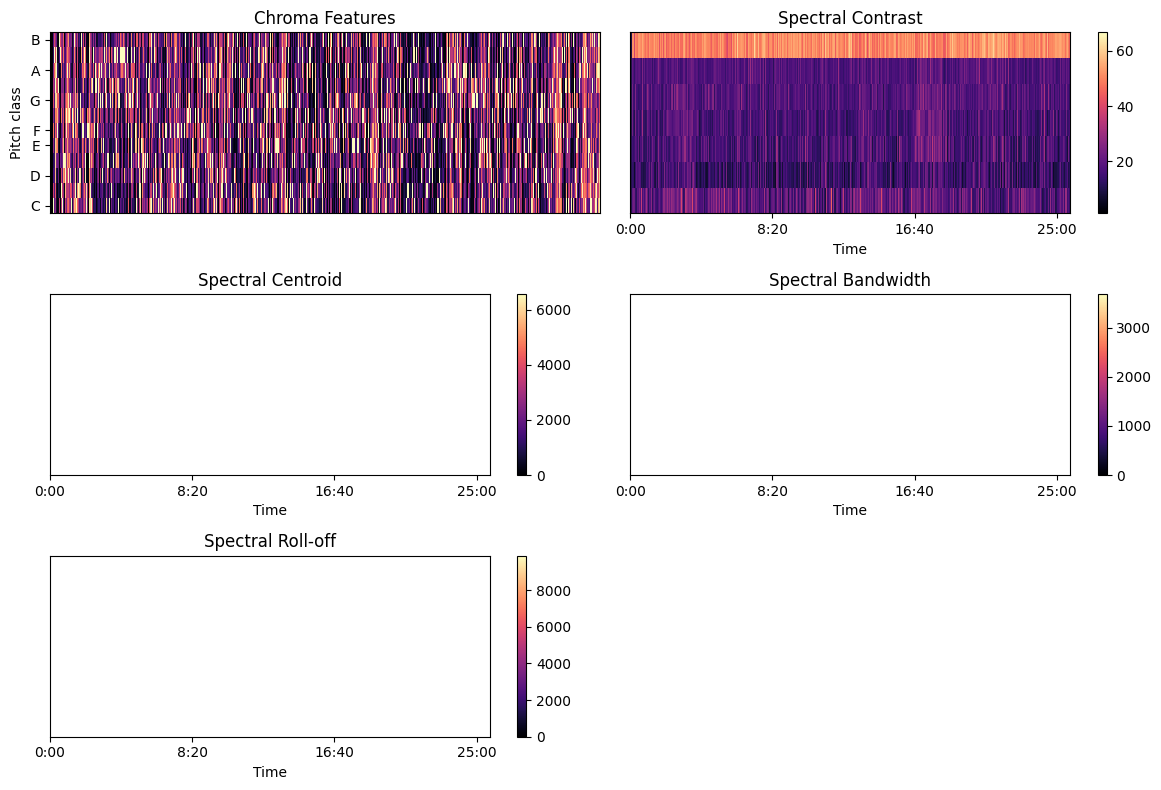

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = '../data/audio/Muppets-02-01-01.wav'
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis='chroma')
plt.title('Chroma Features')

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis='time')
plt.colorbar()
plt.title('Spectral Centroid')
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis='time')
plt.colorbar()
plt.title('Spectral Bandwidth')
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis='time')
plt.colorbar()
plt.title('Spectral Roll-off')
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()



(12, 66659)
(7, 66659)
(1, 66659)
(1, 66659)
(1, 66659)
Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Bandwidth: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Roll-off: [[0. 0. 0. ... 0. 0. 0.]]


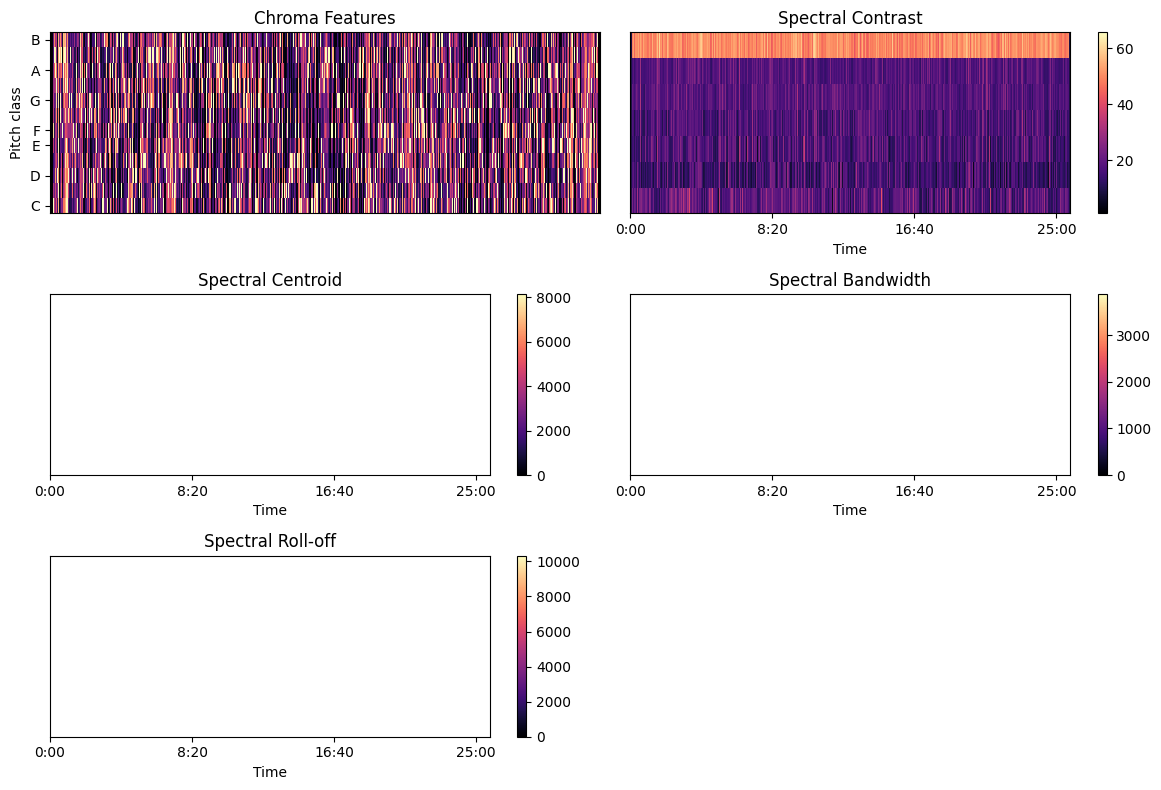

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = '../data/audio/Muppets-02-04-04.wav'
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis='chroma')
plt.title('Chroma Features')

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis='time')
plt.colorbar()
plt.title('Spectral Centroid')
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis='time')
plt.colorbar()
plt.title('Spectral Bandwidth')
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis='time')
plt.colorbar()
plt.title('Spectral Roll-off')
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()


(12, 66299)
(7, 66299)
(1, 66299)
(1, 66299)
(1, 66299)
Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Bandwidth: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Roll-off: [[0. 0. 0. ... 0. 0. 0.]]


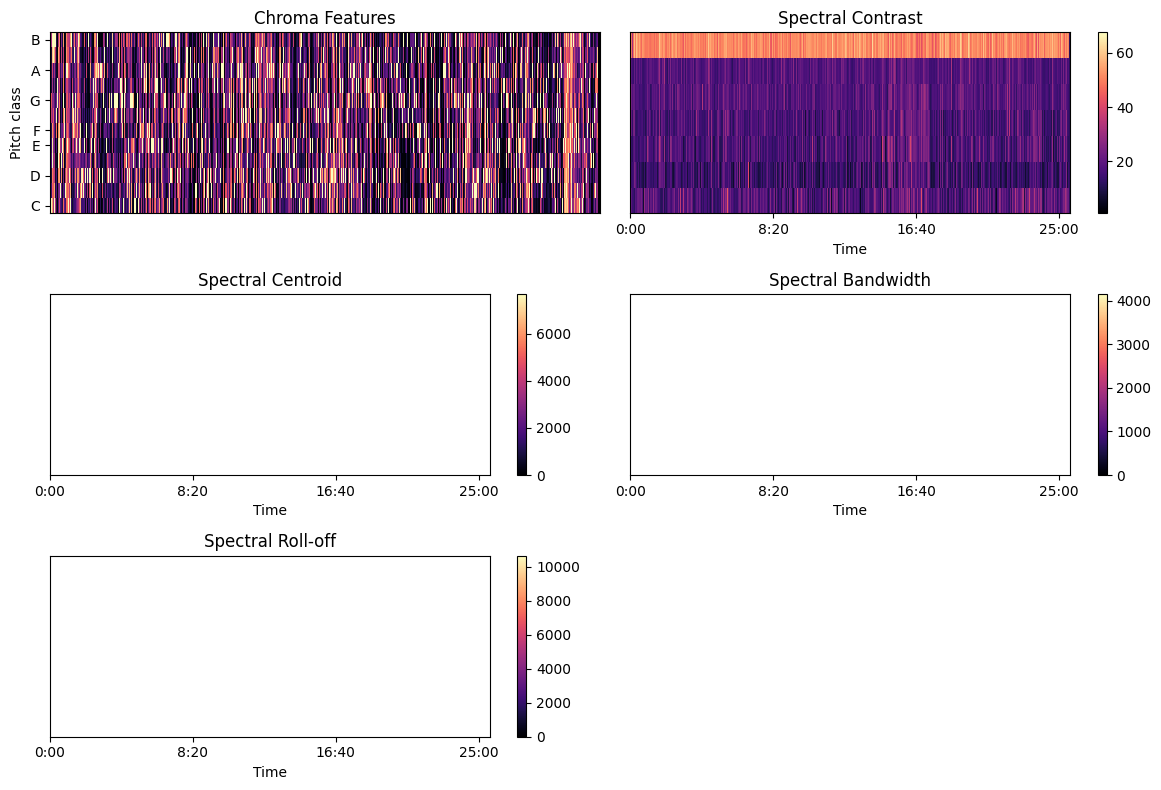

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = '../data/audio/Muppets-03-04-03.wav'
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis='chroma')
plt.title('Chroma Features')

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis='time')
plt.colorbar()
plt.title('Spectral Centroid')
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis='time')
plt.colorbar()
plt.title('Spectral Bandwidth')
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis='time')
plt.colorbar()
plt.title('Spectral Roll-off')
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()


STFT
in sm1 we have used the following timbre features
    loudness rms
    zcr
    mfccs
this leaves us free to use the following timbre features for SM2:
    hnr
    spectral flatness
    tonnetz
    mel centroid
    sharpness
additionally, we compute the fourier tempogram 

For this audio approach, we do not want to operate on the audio files in their basic-from but employ STFT and extract timbre features on its basis. STFT provides a time-frequency representation of an audio signal, breaking it down into short time segments and revealing the frequency content within each segment. Timbre is closely related to spectral characteristics of sound, including the distribution of energy across different frequency bands. By analyzing the STFT, information about the frequency content at different points in time allows for detailed examiniation of spectral features. This aids distinguishing speech and singing patterns. - todo further details, each feature explainen
HNR: 

C:\Users\alina\AppData\Local\Temp\ipykernel_9752\3462702618.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')


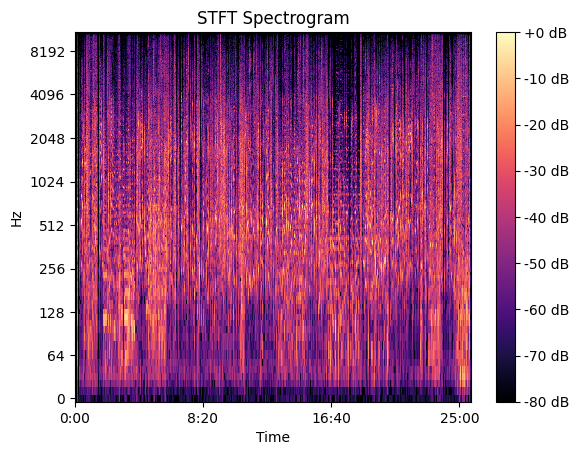

Zero Crossings: [[0.         0.         0.         ... 0.03613281 0.02832031 0.02099609]]
RMS Energy: [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.6840710e-05 1.4777792e-05
 1.2237879e-05]
Harmonic-to-Noise Ratio (HNR): [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.7491660e-05
 -1.5464770e-05 -1.1675758e-05]
Spectral Flatness: [[1.0000007  1.0000007  1.0000007  ... 0.05722385 0.06692996 0.09460584]]
Tonnetz: [[ 0.          0.          0.         ... -0.01516161  0.01703167
   0.01122424]
 [ 0.          0.          0.         ... -0.05483576 -0.05206411
  -0.02138115]
 [ 0.          0.          0.         ... -0.04859439 -0.04497281
  -0.03998579]
 [ 0.          0.          0.         ... -0.03672028 -0.03056692
  -0.00499801]
 [ 0.          0.          0.         ...  0.01351141  0.00037324
  -0.00739452]
 [ 0.          0.          0.         ... -0.00776486 -0.00810733
  -0.00215161]]
Mel-frequency Spectral Centroid: [[   0.            0.            0.         ... 4689.9317

In [22]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file_path = '../data/audio/Muppets-02-01-01.wav'
y, sr = librosa.load(audio_file_path)

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Display the STFT spectrogram
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('STFT Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()
# Feature extraction
#zero_crossings = librosa.feature.zero_crossing_rate(y)
#rms = librosa.feature.rms(y=y)[0]  # Compute RMS energy
hnr = librosa.effects.harmonic(y)
spectral_flatness = librosa.feature.spectral_flatness(y=y)
# Check if pitches and magnitudes are not empty before accessing the maximum value
hop_length = 512  # You can adjust this value based on your needs
n_fft = 2048  # You can adjust this value based on your needs
center = True  # You can set it to False if needed

tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
mel_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center)
sharpness = -librosa.feature.delta(spectral_flatness)

# Display or use the extracted features

print("Harmonic-to-Noise Ratio (HNR):", hnr)
print("Spectral Flatness:", spectral_flatness)
print("Tonnetz:", tonnetz)
print("Mel-frequency Spectral Centroid:", mel_centroid)
print("Perceptual Sharpness:", sharpness)

C:\Users\alina\AppData\Local\Temp\ipykernel_9752\791250290.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')


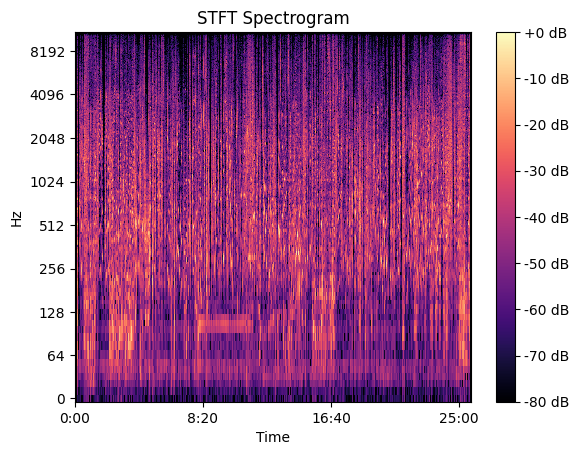

Harmonic-to-Noise Ratio (HNR): [0. 0. 0. ... 0. 0. 0.]
Tonnetz: [[ 0.          0.          0.         ...  0.0448432   0.00675244
   0.01239564]
 [ 0.          0.          0.         ...  0.1414606   0.08569031
   0.02552758]
 [ 0.          0.          0.         ...  0.04957253 -0.00952875
  -0.0147702 ]
 [ 0.          0.          0.         ... -0.02695864  0.01168429
   0.00547853]
 [ 0.          0.          0.         ...  0.08416764  0.01424239
  -0.01793548]
 [ 0.          0.          0.         ... -0.01636204  0.01703281
   0.04656267]]
Mel-frequency Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Perceptual Sharpness: [[-3.7717355e-17 -3.7717355e-17 -3.7717355e-17 ... -3.7717355e-17
  -3.7717355e-17 -3.7717355e-17]]
Spectral Flatness:  [[1.0000007 1.0000007 1.0000007 ... 1.0000007 1.0000007 1.0000007]]


In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file_path = '../data/audio/Muppets-02-04-04.wav'
y, sr = librosa.load(audio_file_path)

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Display the STFT spectrogram
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('STFT Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Feature extraction

# Calculate harmonic component from the STFT
y_harmonic, y_percussive = librosa.effects.hpss(y)
hnr = librosa.effects.harmonic(y_harmonic)

# Calculate tonnetz based on the harmonic component from the STFT
tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)

# Check if pitches and magnitudes are not empty before accessing the maximum value
hop_length = 512  # You can adjust this value based on your needs
n_fft = 2048  # You can adjust this value based on your needs
center = True  # You can set it to False if needed

# Calculate mel-frequency spectral centroid
mel_centroid = librosa.feature.spectral_centroid(S=np.abs(D)**2, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center)

# Calculate sharpness
spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(D)**2)
sharpness = -librosa.feature.delta(spectral_flatness)

# Display or use the extracted features

print("Harmonic-to-Noise Ratio (HNR):", hnr)
print("Tonnetz:", tonnetz)
print("Mel-frequency Spectral Centroid:", mel_centroid)
print("Perceptual Sharpness:", sharpness)
print("Spectral Flatness: ",spectral_flatness)


Audio Feature Extraction & Annotation

In [1]:
from sklearn.preprocessing import normalize

#audio feature extraction
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1
    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )
    y=audio["audio"]
    #applying STFT
    D=librosa.stft(y)
    
    # Calculate harmonic component from the STFT
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    # Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length = 512  # You can adjust this value based on your needs
    n_fft = 2048  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    #HNR
    hnr = librosa.effects.harmonic(y_harmonic)

    #Tonnetz
    # Calculate tonnetz based on the harmonic component from the STFT
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    #Mel centroid
    mel_centroid = librosa.feature.spectral_centroid(S=np.abs(D)**2, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center)
    #spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(D)**2)

    #perceptual sharpness
    sharpness = -librosa.feature.delta(spectral_flatness)

    #ft tempgram
    oenv = librosa.onset_strength(y=y,sr=sr, hop_length = hop_length )
    ft_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr,
                                              hop_length=hop_length)
    #normalize
    hnr =normalize(np.reshape(hnr, (1, -1)))
    tonnetz = normalize(tonnetz)
    mel_centroid = normalize(mel_centroid)
    sharpness = normalize(sharpness)
    spectral_flatness = normalize(spectral_flatness)

    #set features
    audio["hnr"] = hnr
    audio["tonnetz"]=tonnetz
    audio["mel_centroid"] = mel_centroid
    audio["sharpness"]=sharpness
    audio["spectral_flatness"]=spectral_flatness
    audio["ft_tempogram"] = ft_tempogram

NameError: name 'dataset' is not defined

In [ ]:
for i in range(3):
    assert (
        dataset.audios[i]["spectral_flatness"].shape[0]
        == dataset.annotations.loc[dataset.annotations.Video == i].Frame_number.max()
        + 1
    )